# Training the model
**Table of Contents**
1. [Setup](#1-setup)
2. [Dataset Preparation](#2-dataset-preparation)
3. [Training Loop](#3-training-loop)


## 1. Setup

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
####################
# Required Modules #
####################

# Generic/Built-in
import random
import sys 
import os

# Libs
import torch
import numpy as np
from torch.utils.data import DataLoader

In [3]:
# Get the project directory 
current_dir = os.path.abspath('') # Current '\notebooks' directory
project_dir = os.path.abspath(os.path.join(current_dir, '..')) # Move up one level to project root directory

# Add the project directory to sys.path
sys.path.append(project_dir)

# Move up to project directory
os.chdir(project_dir)
os.getcwd()

# Import custom modules
from src.data_preparation import *
from src.models import *
from src.train_eval import *

c:\Users\Ryan Lee\.conda\envs\term6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Seeding
SEED = 42

# To be safe, seed all modules for full reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using CUDA
np.random.seed(SEED)
random.seed(SEED)

## 2. Dataset Preparation

In [5]:
train_dataset, val_dataset, test_dataset = prepare_datasets(
    sequence_size=250,
    stride=25,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    random_state=SEED,
    load_if_exists=True
)

✅ HARDataset object and split indices loaded from saved_components
✅ Created train, validation, and test datasets.


In [6]:
print(f"Train Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")
print(f"Test Set: {len(test_dataset)} samples")
print(f"Total: {len(train_dataset) + len(val_dataset) + len(train_dataset)} samples")


Train Set: 70363 samples
Validation Set: 8796 samples
Test Set: 8796 samples
Total: 149522 samples


## 3. Training Loop

In [32]:
# Hyperparameters
batch_size = 256
learning_rate = 0.001
num_epochs = 20

In [33]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [34]:
# Load model
model = HarTransformer()
#model.load_state_dict(torch.load("models/HarTransformer_2025-04-02_20-51-37/HarTransformer_best_F1.pth"))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [35]:
training_loss_history, validation_loss_history, accuracy_history, f1_history, precision_history, recall_history, normalizer = train_HAR70_model(
    model, 
    optimizer, 
    train_dataloader, 
    validation_dataloader, 
    num_epochs = num_epochs
)

Beginning training session...
Model moved to cuda
(1) Creating subdirectory (models\HarTransformer_2025-04-11_15-34-51) for saving model params...
(2) Computing normalization statistics from the training dataset...
(3) Beginning training loop (20 epochs)...
Epoch [1/20] | Time: 24.19s
(Training) Loss: 0.4180
(Validation) Loss: 0.2176, Accuracy: 0.5523, F1: 0.5450, Precision: 0.5381, Recall: 0.5523
✅ Model saved: models\HarTransformer_2025-04-11_15-34-51\HarTransformer_best_F1.pth
Epoch [2/20] | Time: 45.52s
(Training) Loss: 0.2113
(Validation) Loss: 0.2004, Accuracy: 0.5586, F1: 0.5498, Precision: 0.5637, Recall: 0.5586
✅ Model saved: models\HarTransformer_2025-04-11_15-34-51\HarTransformer_best_F1.pth
Epoch [3/20] | Time: 71.69s
(Training) Loss: 0.1824
(Validation) Loss: 0.1903, Accuracy: 0.5617, F1: 0.5566, Precision: 0.5646, Recall: 0.5617
✅ Model saved: models\HarTransformer_2025-04-11_15-34-51\HarTransformer_best_F1.pth
Epoch [4/20] | Time: 70.32s
(Training) Loss: 0.1674
(Validati

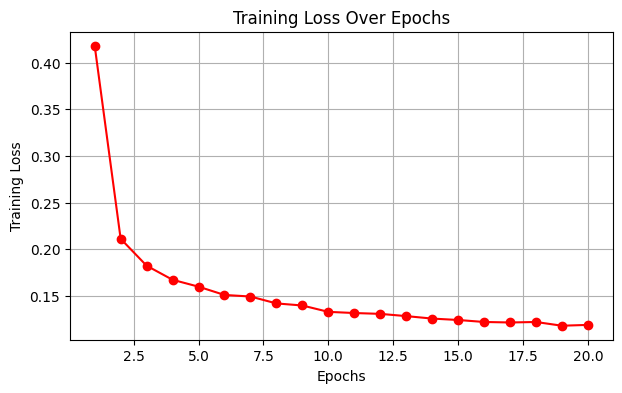

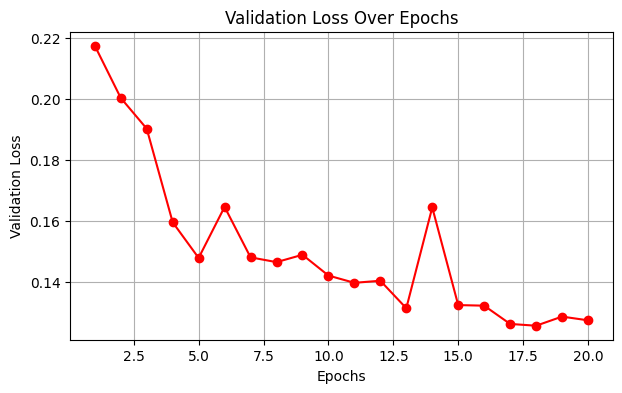

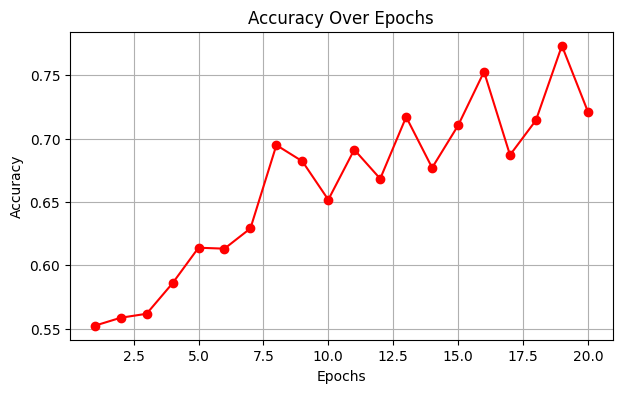

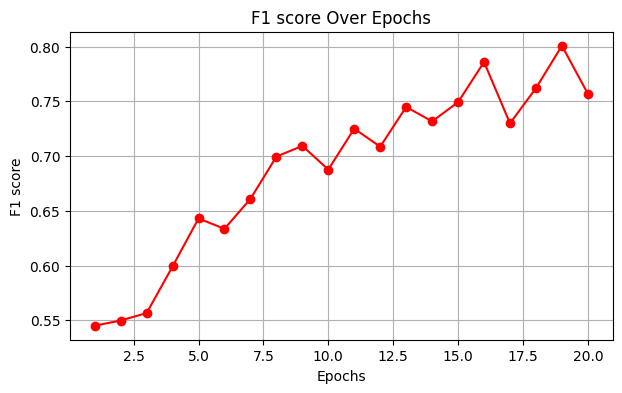

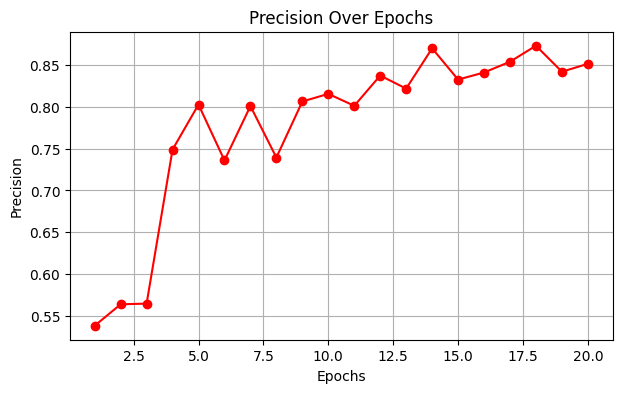

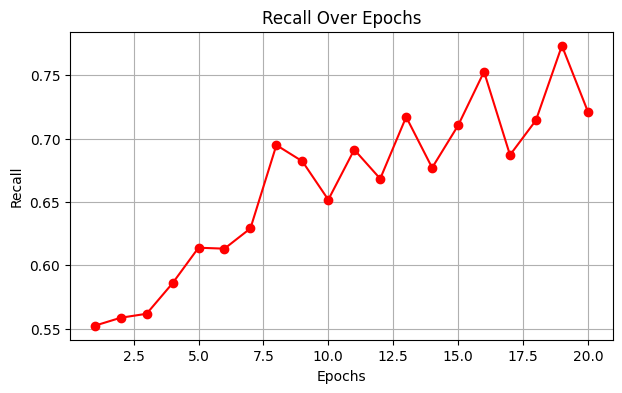

✅ Plots saved to: results\HarTransformer_2025-04-11_15-53-02
✅ Metric histories saved to: results\HarTransformer_2025-04-11_15-53-02\metric_histories.pth


In [36]:
save_training_plots_and_metric_history(training_loss_history, validation_loss_history, accuracy_history, f1_history, precision_history, recall_history, type(model).__name__)

In [37]:
# Test metrics
loss, accuracy, f1, precision, recall, conf_matrix = evaluate_HAR70_model(model, test_dataloader, normalizer)
print(f"(Test) Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

(Test) Loss: 0.1247, Accuracy: 0.7453, F1: 0.7855, Precision: 0.8738, Recall: 0.7453
